In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

This model uses a neural network and GridSearchCV to predict share price impacts of Interest changes

# Read the CSV and Perform Basic Data Cleaning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df_stock1 = pd.read_csv("../../static/data/WBC.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5746,27/07/2022,21.100000,21.530001,21.049999,21.41,21.41,5459593.0,1.35,2.5,125.0
5747,28/07/2022,21.610001,21.650000,21.410000,21.43,21.43,5165682.0,1.35,2.5,125.0
5748,29/07/2022,21.510000,21.600000,21.469999,21.51,21.51,7000330.0,1.35,2.5,125.0
5749,1/08/2022,21.500000,21.660000,21.230000,21.66,21.66,6824049.0,1.35,2.5,125.0
5750,2/08/2022,21.610001,22.020000,21.559999,22.00,22.00,6402716.0,1.35,2.5,125.0


In [4]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

df_mongo = pd.DataFrame(list(db.wbc.find()))
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
# print(last_val)
print(last_date,last_close)
df_mongo.tail

12/08/2022 22.65999984741211


<bound method NDFrame.tail of                            _id        Date       Open       High        Low  \
0     62eccb780b9367ab254e73d6   3/01/2000  10.435952  10.435952  10.435952   
1     62eccb780b9367ab254e73d7   4/01/2000  10.448864  10.448864  10.240284   
2     62eccb780b9367ab254e73d8   5/01/2000  10.063487  10.081366  10.001907   
3     62eccb780b9367ab254e73d9   6/01/2000  10.081366  10.111163   9.942312   
4     62eccb780b9367ab254e73da   7/01/2000  10.031704  10.061501   9.982042   
...                        ...         ...        ...        ...        ...   
5721  62f22301af5bd29652105878  08/08/2022  21.940001  22.100000  21.840000   
5722  62f370c0fe264916b3667e94  09/08/2022  22.000000  22.020000  21.730000   
5723  62f6ffd89f1566d03b3f9628  10/08/2022  22.000000  22.290001  21.915001   
5724  62f6ffd89f1566d03b3f9629  11/08/2022  22.400000  22.490000  22.270000   
5725  62f6ffd89f1566d03b3f962a  12/08/2022  22.400000  22.690001  22.379999   

          Close  Adj 

# Use `RBA`,`FED` and `CPI` for the X values

In [5]:
X = df_mongo[["RBA","FED","CPI"]]
y = df_mongo["Close"].values.reshape(-1, 1)
print(X.shape, y.shape)

(5726, 3) (5726, 1)


In [6]:
X

,RBA,FED,CPI
0,5.00,5.5,69.7
1,5.00,5.5,69.7
2,5.00,5.5,69.7
3,5.00,5.5,69.7
4,5.00,5.5,69.7
...,...,...,...
5721,1.85,2.5,125.0
5722,1.85,2.5,125.0
5723,1.85,2.5,125.0
5724,1.85,2.5,125.0


# Create a Train Test Split

In [7]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.info)

(4294, 3) (4294, 1)
(1432, 3) (1432, 1)
<bound method DataFrame.info of        RBA   FED    CPI
4496  1.50  1.25  112.1
4995  1.00  2.00  115.4
5416  0.10  1.25  118.8
1822  6.25  5.25   86.6
99    6.00  6.50   70.2
...    ...   ...    ...
905   4.75  1.00   79.1
5192  0.25  1.25  116.2
3980  2.00  0.25  108.0
235   6.25  6.50   73.1
5157  0.25  1.25  114.4

[4294 rows x 3 columns]>


In [8]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit the model

In [9]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.5103232878441908
Testing Score: 0.5078389048977525


In [10]:
# X_train = X_train.reshape((X_train.shape[0], 1))

In [11]:
#Linear Regression Residual showing difference actual vs predicted
# residual = pd.DataFrame([model.predict(X_train),y_train,(model.predict(X_train)-y_train)])
# residual.tail

Text(0.5, 1.0, 'Residual Plot')

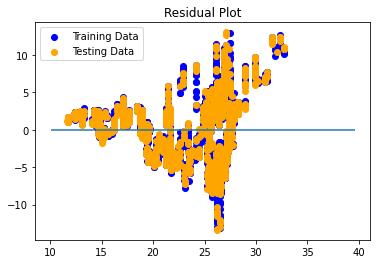

In [12]:
# Plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

In [13]:
# Linear Regression: X_test predictions to variable
predictions = model.predict(X_test)

#### R2 Score is a very popular metric used for evaluating the performance of linear regression models. Where R2 Score is between 0 and 1, the closer to 1, the better the regression fit.
#### Use MSE or MAE when comparing two or more models, the lower the value of MSE or MAE, the better. MSE (Mean Square Error): Uses Euclidean distance to calculate the error. MSE gives the magnitude of the error only.

In [14]:
# Used X_test, y_test, and model.predict(X_test) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 20.80608355346185, R2: 0.5078389048977525


#### Lasso regression imposes a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. It comes with a parameter, alpha , and the higher the alpha , the more feature coefficients are zero. When alpha is 0 , Lasso regression produces the same coefficients as a linear regression.

In [15]:
# LASSO model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 20.807835494917263, R2: 0.5077974632961635


In [16]:
# Ridge model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 20.80608412097467, R2: 0.5078388914734225


In [17]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 20.80830158708169, R2: 0.5077864380386


# Hyperparameter Tuning

In [18]:
y_target = df_mongo["Close"]
y_target.shape

(5726,)

In [19]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_target, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4294, 3) (4294,)
(1432, 3) (1432,)


In [20]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4294, 3) (4294,)
(1432, 3) (1432,)


#### GridSearchCV and RandomizedSearchCV are techniques to evaluate models for a given hyperparameter vector using cross-validation, hence the “CV” suffix of the class name.
#### We are executing many models together is to find which machine learning model works best for this particular dataset.

In [21]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [22]:
regressors = [
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [23]:
from time import time
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

RandomForestRegressor()
	Training time: 0.241s
	Prediction time: 0.023s
	Explained variance: 0.979354715506385
	Mean absolute error: 0.6781652184248806
	R2 score: 0.9793289564180208

DecisionTreeRegressor()
	Training time: 0.003s
	Prediction time: 0.001s
	Explained variance: 0.9793710628981334
	Mean absolute error: 0.677500423890599
	R2 score: 0.9793439995643506

KNeighborsRegressor()
	Training time: 0.004s
	Prediction time: 0.006s
	Explained variance: 0.9752188202554671
	Mean absolute error: 0.7215408199332467
	R2 score: 0.9750621950115101

GradientBoostingRegressor()
	Training time: 0.128s
	Prediction time: 0.003s
	Explained variance: 0.9712775926719357
	Mean absolute error: 0.8346786162256248
	R2 score: 0.9712381671915724

KNeighborsRegressor()
	Training time: 0.004s
	Prediction time: 0.006s
	Explained variance: 0.9752188202554671
	Mean absolute error: 0.7215408199332467
	R2 score: 0.9750621950115101

ExtraTreesRegressor()
	Training time: 0.173s
	Prediction time: 0.023s
	Explained v

#### By comparing these results, we can quickly see that RandomForestRegressor and DecisionTreeRegressor are the best models for our data
#### Machine learning models have parameters, which are the internal coefficients set by training or optimizing the model on a training dataset.
#### Parameters are different from hyperparameters. Parameters are learned automatically; hyperparameters are set manually to help guide the learning process.

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [27]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [28]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.6791 degrees.
Accuracy = 97.02%.
Model Performance
Average Error: 0.6773 degrees.
Accuracy = 97.03%.
Improvement of 0.01%.


In [29]:
# Hyperparameter tuning has not improved accuracy significantly

In [30]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)
y_test_pred = model_rfr.predict(X_test)
y_test_pred

array([23.19247069, 25.48796332, 33.07768605, ..., 16.19918445,
       13.19000146, 22.05253227])

In [31]:
#RandomForestRegressor Residual showing difference actual vs predicted
residual_dtr = pd.DataFrame([model_rfr.predict(X_train),y_train,(model_rfr.predict(X_train)-y_train)])
residual_dtr.tail

<bound method NDFrame.tail of         0          1          2          3          4          5     \
0  32.321928  29.674561  25.718166  24.554961  11.955733  31.106792   
1  31.860001  29.889999  26.200001  25.575878  11.789735  30.313623   
2   0.461927  -0.215438  -0.481835  -1.020917   0.165998   0.793169   

        6          7          8          9     ...       4284       4285  \
0  28.905664  12.848556  15.945019  17.254342  ...  29.899340  11.851979   
1  29.190001  12.907128  16.289103  17.202883  ...  30.030001  12.025132   
2  -0.284337  -0.058572  -0.344084   0.051459  ...  -0.130661  -0.173153   

        4286       4287       4288       4289       4290       4291  \
0  25.493737  22.972965  22.053998  16.199184  17.525828  31.829517   
1  24.389999  21.374481  21.165901  16.348698  18.160000  30.899635   
2   1.103738   1.598484   0.888097  -0.149514  -0.634172   0.929882   

        4292       4293  
0  13.296188  16.516643  
1  13.905332  14.910000  
2  -0.609144   1.

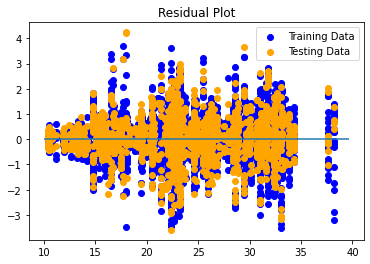

In [32]:
# Make predictions using fitted model
predictions1 = model_rfr.predict(X_test)

# Plotted the difference between the model predicted values and actual y values, versus the model predicted values
plt.scatter(model_rfr.predict(X_train), y_train - model_rfr.predict(X_train), c="blue", label="Training Data")
plt.scatter(model_rfr.predict(X_test), y_test - model_rfr.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

# Save the Model

In [33]:
import pickle
filename = '../../static/wbc_model_rfr.sav'
pickle.dump(model, open(filename, 'wb'))
model_in_rfr = pickle.load(open(filename, 'rb'))

In [34]:
# from joblib import dump,load
# model_in_rfr = load('WBC_model_rfr.sav')

In [35]:
rba = float(0.85)
fed = float(1.75)
cpi = float(125.00)
input =40
rfr=[]

def randomforest(rba,fed,cpi):
    for i in range(0,input):
      rfr.append([rba,fed,cpi])
      np.round_(rfr,2,out = None) 
      df = pd.DataFrame(rfr, columns = ['RBA','FED',"CPI"])
      df.round(2)
      pred_rf=model_in_rfr.predict(df)
      df['Prediction'] = pred_rf
      df['Prediction'] = df['Prediction'].astype(float).round(2)
      rba+=0.01
      fed+=0.01
      cpi+=0.01
      print(df)
    my_rforest = df.to_dict(orient='records')
    for dict_value in my_rforest:
      for k, v in dict_value.items():
        dict_value[k] = round(v, 2)
    return my_rforest
# print(my_rforest)
my_rf = randomforest(rba,fed,cpi)
print(my_rf)


    RBA   FED    CPI  Prediction
0  0.85  1.75  125.0       31.55
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       31.55
1  0.86  1.76  125.01       31.56
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       31.55
1  0.86  1.76  125.01       31.56
2  0.87  1.77  125.02       31.58
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       31.55
1  0.86  1.76  125.01       31.56
2  0.87  1.77  125.02       31.58
3  0.88  1.78  125.03       31.60
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       31.55
1  0.86  1.76  125.01       31.56
2  0.87  1.77  125.02       31.58
3  0.88  1.78  125.03       31.60
4  0.89  1.79  125.04       31.61
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       31.55
1  0.86  1.76  125.01       31.56
2  0.87  1.77  125.02       31.58
3  0.88  1.78  125.03       31.60
4  0.89  1.79  125.04       31.61
5  0.90  1.80  125.05       31.63
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       31.55
1  0.86  1.76  1

In [36]:
rba = float(0.85)
fed = float(1.75)
cpi = float(125.00)
def rforest(rba,fed,cpi):
    dtr =[[rba,fed,cpi]]
    df = pd.DataFrame (dtr, columns = ['RBA','FED',"CPI"])
    pred_dtr=model_in_rfr.predict(df)
    df['Prediction'] = pred_dtr
    print(df)
    df_dict = df.to_dict(orient='records')
    return pred_dtr
Pred_rf = rforest(rba,fed,cpi)
print(Pred_rf)

    RBA   FED    CPI  Prediction
0  0.85  1.75  125.0   31.548689
[31.54868853]


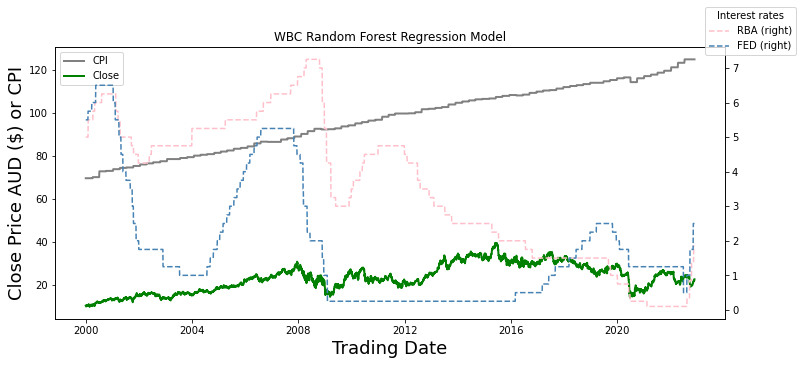

In [37]:
x = np.arange(2000,2024,4)
ax = df_mongo.plot(y=["CPI","Close"], figsize=(12, 5),color=['grey','green'],linewidth=2)
df_mongo.plot(y=["RBA","FED"],secondary_y=True, ax=ax,color=['pink','steelblue'],linestyle='dashed')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=-4, title="Interest rates")
ax.legend(loc='upper left')
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax.set_xticklabels(x, rotation=0)
ax.set_title('WBC Random Forest Regression Model')
ax.set_xlabel('Trading Date', fontsize=18)
ax.set_ylabel('Close Price AUD ($) or CPI', fontsize=18)
plt.savefig('../../static/data/images/WBC_tree.png')

#Save predicted error to MongoDB

In [38]:
# Module used to connect Python with MongoDb
import pymongo

In [39]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

name = 'WBC'

In [40]:
# query the companys collection
companys = db.find({
      'model': 'RFR',
      'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62ee244c8b20105d26c6c42b'), 'model': 'RFR', 'name': 'WBC', 'date': '05/08/2022', 'predicted': 31, 'actual': 21, 'difference': 10.5984, 'accuracy': 97.13}


In [41]:
#save last price actual to variable
actual_price = df_mongo.iloc[-1,5]
actual_date = df_mongo.iloc[-1,1] 
actual_price = int(actual_price)
base_accuracy=round(base_accuracy,2)
print(base_accuracy,actual_price,actual_date)


97.02 22 12/08/2022


In [42]:
# Set keys and values of company
predicted = int(Pred_rf)
difference = Pred_rf-actual_price
difference=difference[0]
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference},accuracy {base_accuracy}')

date 12/08/2022,predicted 31,actual 22, difference 9.548688533900613,accuracy 97.02


In [43]:
# Delete a document from a collection
db.delete_one(
    {'model': 'RFR','name': name}
)


In [44]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'RFR',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'difference': round(difference,4),
      'accuracy': base_accuracy        
    }
)

# query the classroom collection
companys = db.find({
  'model': 'RFR',
  'name': name,})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f86c94e8aa99df83075c2c'), 'model': 'RFR', 'name': 'WBC', 'date': '12/08/2022', 'predicted': 31, 'actual': 22, 'difference': 9.5487, 'accuracy': 97.02}
